# Chatbot with Collection Schema 

## Review

We extended our chatbot to save semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

We also introduced a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information. 

## Goals

There are [trade-offs](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_200) between saving a single profile versus a collection of memories. 

Here we'll update our chatbot to [save memories to a collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection), rather than a single schema. 

We'll also show how to use [Trustcall](https://github.com/hinthornw/trustcall) to update this collection. 


In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall

In [2]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Defining a collection schema

Similar to the profile schema, we can define a collection schema. 

In this case, we'll structure it in a way that is amenable to storing an open-ended collection of memories about the user. 

This means that [the fields](https://langchain-ai.github.io/langgraph/concepts/memory/#collection) of the schema are more general than a profile of pre-defined user information.

We can use them to store any memories that we want to save about the user. 

In [3]:
from pydantic import BaseModel, Field
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    context: str = Field(description="Additional context for the memory. For example: This was mentioned while discussing career options in Europe.")

In [ ]:
_set_env("OPENAI_API_KEY")

LangChain's chat model [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface has a [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) method to enforce structured output.

This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

In [4]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(Memory)
# Invoke the model to produce structured output that matches the schema
memory_1 = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
memory_1

Memory(content='User likes to bike.', context='User introduced themselves as Lance.')

In [5]:
memory_2 = model_with_structure.invoke([HumanMessage("I also like to go to bakeries.")])
memory_2

Memory(content='User likes to go to bakeries.', context='User mentioned this while discussing personal interests.')

Save each memory to the store. 

In [6]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_1
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_2
in_memory_store.put(namespace_for_memory, key, value)

Search for memories in the store. 

In [7]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': Memory(content='User likes to bike.', context='User introduced themselves as Lance.'), 'key': '0b4bfee3-e1f4-4dae-ab7f-ac9ef3d22ab2', 'namespace': ['1', 'memories'], 'created_at': '2024-10-29T16:35:30.149194+00:00', 'updated_at': '2024-10-29T16:35:30.149197+00:00'}
{'value': Memory(content='User likes to go to bakeries.', context='User mentioned this while discussing personal interests.'), 'key': 'b09b4847-d03c-4652-952e-04e3559c3515', 'namespace': ['1', 'memories'], 'created_at': '2024-10-29T16:35:30.149238+00:00', 'updated_at': '2024-10-29T16:35:30.149239+00:00'}


## Updating collection schema

We discussed the challenges with updating a profile schema in the last lesson. 

The same applies for collections! 

We want the ability to update the collection with new memories as well as update existing memories in the collection. 

Now we'll show that [Trustcall](https://github.com/hinthornw/trustcall) can be also used to update a collection. 

This enables both addition of new memories as well as [updating existing memories in the collection](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions
).

Let's define a new extractor with Trustcall and pass a list of [messages](https://python.langchain.com/docs/concepts/messages/).

In [8]:
from trustcall import create_extractor

conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco."""

trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Instruction
instruction = f"""Extract memories from the following conversation:
<convo>
{conversation}
</convo>"""

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=instruction)]})
memories = result["responses"]
memories

memories[0].model_dump(mode="json")

{'content': 'User likes biking around San Francisco.',
 'context': 'User introduced themselves as Lance.'}

In [10]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_wWcGrmejJUkSfANUSazicuht)
 Call ID: call_wWcGrmejJUkSfANUSazicuht
  Args:
    content: User likes biking around San Francisco.
    context: User introduced themselves as Lance.


Now, we can update this collection of memories by passing them along with any new messages to the extractor. 

In [11]:
# Update the conversation
updated_conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco.
Assistant: San Francisco is a great city! Where do you go after biking?
User: I really like to go to a bakery."""

# Update the instruction
updated_instruction = f"""Reflect on following interaction. Use the provided tools to retain any necessary memories about the user. 
Use parallel tool calling to handle updates & insertions simultaneously:
<convo>
{updated_conversation}
</convo>"""

existing_memories = [(str(i), "Memory", memory.model_dump()) for i, memory in enumerate(memories)] if memories else None

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=updated_instruction)], 
                                     "existing": existing_memories})

updated_memories = result["responses"]
updated_memories

[Memory(content='User likes biking around San Francisco and going to a bakery afterwards.', context='User introduced themselves as Lance.'),
 Memory(content='User likes to go to a bakery after biking.', context='This was mentioned during a conversation about biking in San Francisco.')]

This tells us that we updated the first memory in the collection by specifying the `json_doc_id`. 

In addition, it tells us that we inserted a new memory into the collection. 

In [12]:
result["response_metadata"]

[{'id': 'call_b3jkBzwqBS0czmM421MO4RjX', 'json_doc_id': '0'},
 {'id': 'call_tMgUe3LmDsoz5yRXelSR7AxY'}]

In [13]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_b3jkBzwqBS0czmM421MO4RjX)
 Call ID: call_b3jkBzwqBS0czmM421MO4RjX
  Args:
    content: User likes biking around San Francisco and going to a bakery afterwards.
    context: User introduced themselves as Lance.
  Memory (call_tMgUe3LmDsoz5yRXelSR7AxY)
 Call ID: call_tMgUe3LmDsoz5yRXelSR7AxY
  Args:
    content: User likes to go to a bakery after biking.
    context: This was mentioned during a conversation about biking in San Francisco.


Trace: 

https://smith.langchain.com/public/dd5d82fc-faec-409c-8063-ead6aaed94ff/r

## Chatbot with collection schema updating

Now, let's bring Trustcall into our chatbot to create and update a memory collection.

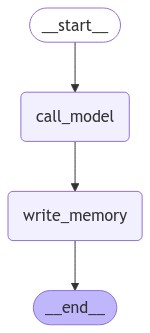

In [33]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Schema 
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    context: str = Field(description="Additional context for the memory. For example: This was mentioned while discussing career options in Europe.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
    system_msg = f"""You are a helpful assistant with memory that provides information about the user.  
    If you have memory for this user, use it to personalize your responses.
    Here is the memory (it may be empty): {info}"""

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Format the chat history for the Trustcall extractor
    system_msg = """Reflect on following interaction. Use the provided tools to retain any necessary memories about the user. 
    Use parallel tool calling to handle updates & insertions simultaneously:"""
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=system_msg)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?


In [8]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun, Lance! San Francisco has some great biking routes. Do you have a favorite trail or area you like to explore?


In [12]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'value': {'content': "User's name is Lance.", 'context': 'User introduced themselves.'}, 'key': '6aa72d03-ce33-4abe-9e71-42f4f43f6243', 'namespace': ['memories', '1'], 'created_at': '2024-10-28T18:00:19.580884+00:00', 'updated_at': '2024-10-28T18:00:29.790734+00:00'}
{'value': {'content': 'User likes to bike around San Francisco.', 'context': 'User shared their interest in biking.'}, 'key': '369dd43e-04e1-4573-913d-ab615622d383', 'namespace': ['memories', '1'], 'created_at': '2024-10-28T18:00:29.790718+00:00', 'updated_at': '2024-10-28T18:00:29.790719+00:00'}


In [13]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Biking and bakeries make a great combination! San Francisco has some amazing bakeries. Do you have a favorite bakery you like to visit after a ride?


Continue the conversation in a new thread.

In [14]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you enjoy visiting bakeries, Lance, and you're in San Francisco, here are a few recommendations you might like:

1. **Tartine Bakery** - Known for its delicious bread and pastries, it's a must-visit.
2. **B. Patisserie** - Offers a delightful selection of French pastries and cakes.
3. **Arizmendi Bakery** - A worker-owned cooperative with great sourdough and pastries.
4. **Mr. Holmes Bakehouse** - Famous for their cruffins and other creative pastries.
5. **Craftsman and Wolves** - Known for their "Rebel Within" muffin and other innovative treats.

Enjoy your bakery adventures!


### LangSmith 

https://smith.langchain.com/public/c87543ec-b426-4a82-a3ab-94d01c01d9f4/r

## TODO: Add Studio and closing thoughts 